In [1]:
# Importing torch packages for Neural Network building
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__() 
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), # Input=28x28x1 Kernel=3x3x1x10 Output=28x28x10 RF=3x3
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(0.04),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), # Input=28x28x10 Kernel=3x3x10x10 Output=28x28x10 RF=5x5
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(0.04)
        ) #output_size=28x28x10
    self.conv2 = nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2), # Input=28x28x10 Output=14x14x10 RF=6x6
        )#output_size=14x14x10

    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), #Input=14x14x10 Kernel=3x3x10x10 Output=12x12x10 RF=10x10
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(0.04),
        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Input=12x12x10 Kernel=3x3x10x12 Output=10x10x12 RF=14x14
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(0.04),
        nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=10x10x12 Kernel=3x3x12x16 Output=8x8x16 RF=18x18
        nn.ReLU(),            
        nn.BatchNorm2d(16),
        nn.Dropout(0.04),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=8x8x16 Kernel=3x3x16x16 Output=6x6x16 RF=22x22
        nn.ReLU(),         
        nn.BatchNorm2d(16),
        nn.Dropout(0.04)
        )#output_size=6x6x16

    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=6x6x16 Kernel=3x3x16x16 Output=4x4x16 RF=26x26
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.AvgPool2d(kernel_size=(4,4)), #Input=4x4x16 Kernel=4x4x16x16 Output=1x1x16
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) #Input=1x1x16 Kernel=1x1x16x10 Output=1x1x10
        ) 


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
              ReLU-6           [-1, 10, 28, 28]               0
       BatchNorm2d-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
             ReLU-11           [-1, 10, 12, 12]               0
      BatchNorm2d-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []
misclassified=[]
lambda1 = 0.0002
lambda2 = 0.0001

def train(model, device, train_loader, optimizer, epoch, reg):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    #Calculate Loss
    regularization_loss1 = 0
    regularization_loss2 = 0
    if (reg=='None'): #No Regularization
      loss = F.nll_loss(y_pred, target)
      train_losses.append(loss)
    
    elif (reg=='L1'): #Loss with L1
      loss = F.nll_loss(y_pred, target)
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
      loss += (lambda1*regularization_loss1)
      train_losses.append(loss)
    
    elif (reg=='L2'): #Loss with L2
      loss = F.nll_loss(y_pred, target)
      for param in model.parameters():
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda2*regularization_loss2)
      train_losses.append(loss)

    elif (reg=='L1L2'): #Loss with L1 and L2
      loss = F.nll_loss(y_pred, target)
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
      train_losses.append(loss)

    elif (reg== 'GBN'): #Loss with GBN
      loss = F.nll_loss(y_pred, target)
      train_losses.append(loss)
    
    else: #Loss with GBN, L1 and L2
      loss = F.nll_loss(y_pred, target)
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
      train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  train_epoch_end.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

#Without any regularization
EPOCHS = 25
epoch=0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch, reg='None')
    scheduler.step()
    test(model, device, test_loader)
test_loss_noreg=test_losses
test_acc_noreg=test_acc

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.03983945772051811 Batch_id=937 Accuracy=93.61: 100%|██████████| 938/938 [00:18<00:00, 50.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9821/10000 (98.21%)

EPOCH: 2


Loss=0.03665448725223541 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:18<00:00, 50.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.015406475402414799 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:18<00:00, 50.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.21655410528182983 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:18<00:00, 50.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.10744281858205795 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:18<00:00, 51.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.007798740640282631 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:18<00:00, 50.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.07310738414525986 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:18<00:00, 49.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.1768764853477478 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:18<00:00, 51.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


Loss=0.012087077833712101 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:19<00:00, 48.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)

EPOCH: 10


Loss=0.022553307935595512 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:18<00:00, 51.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

EPOCH: 11


Loss=0.0015376771334558725 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:18<00:00, 50.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.021929223090410233 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:18<00:00, 50.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.0007085532997734845 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:18<00:00, 51.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.014019645750522614 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:18<00:00, 49.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.0021639717742800713 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 50.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)

EPOCH: 16


Loss=0.015778834000229836 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 49.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.016696516424417496 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:18<00:00, 50.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

EPOCH: 18


Loss=0.017882214859128 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:18<00:00, 50.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9946/10000 (99.46%)

EPOCH: 19


Loss=0.09398980438709259 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:18<00:00, 50.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.00526704266667366 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:18<00:00, 49.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.0020573462825268507 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:18<00:00, 49.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

EPOCH: 22


Loss=0.018916824832558632 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:18<00:00, 50.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Loss=0.008090495131909847 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 49.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.017253346741199493 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:19<00:00, 48.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.007829603739082813 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:18<00:00, 49.86it/s]



Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)



In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

#With L1 Regularisation
EPOCHS = 25
epoch=0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch, reg='L1')
    scheduler.step()
    test(model, device, test_loader)
test_loss_l1=test_losses
test_acc_l1=test_acc

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.15686637163162231 Batch_id=937 Accuracy=93.20: 100%|██████████| 938/938 [00:20<00:00, 45.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9830/10000 (98.30%)

EPOCH: 2


Loss=0.19075247645378113 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:21<00:00, 44.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.20016232132911682 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:21<00:00, 44.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.11912808567285538 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:20<00:00, 46.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.12385034561157227 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:19<00:00, 47.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.2764780819416046 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:20<00:00, 45.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9871/10000 (98.71%)

EPOCH: 7


Loss=0.11065616458654404 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:20<00:00, 46.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.09833329916000366 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:20<00:00, 45.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.13061955571174622 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:20<00:00, 45.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 10


Loss=0.09998897463083267 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:21<00:00, 44.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


Loss=0.10681381821632385 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:21<00:00, 44.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.11802352219820023 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:20<00:00, 44.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.087659552693367 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:22<00:00, 41.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.09042631834745407 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:21<00:00, 44.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.09257377684116364 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:20<00:00, 45.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.09042821079492569 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:20<00:00, 44.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


Loss=0.10895197093486786 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:20<00:00, 44.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)

EPOCH: 18


Loss=0.28379589319229126 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:20<00:00, 44.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9946/10000 (99.46%)

EPOCH: 19


Loss=0.15271270275115967 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:20<00:00, 46.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.119310662150383 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:21<00:00, 43.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9947/10000 (99.47%)

EPOCH: 21


Loss=0.09029485285282135 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:20<00:00, 45.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 22


Loss=0.13021472096443176 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:21<00:00, 43.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9949/10000 (99.49%)

EPOCH: 23


Loss=0.0880490317940712 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:20<00:00, 44.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.0911247581243515 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:20<00:00, 44.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9946/10000 (99.46%)

EPOCH: 25


Loss=0.08737103641033173 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:20<00:00, 45.48it/s]



Test set: Average loss: 0.0162, Accuracy: 9948/10000 (99.48%)



In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

#With L2 Regularisation
EPOCHS = 25
epoch=0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch, reg='L2')
    scheduler.step()
    test(model, device, test_loader)
test_loss_l2=test_losses
test_acc_l2=test_acc

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.1408771276473999 Batch_id=937 Accuracy=93.95: 100%|██████████| 938/938 [00:21<00:00, 43.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9884/10000 (98.84%)

EPOCH: 2


Loss=0.2956153154373169 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:21<00:00, 43.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9909/10000 (99.09%)

EPOCH: 3


Loss=0.0177177581936121 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:21<00:00, 42.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.10723551362752914 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:21<00:00, 43.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.07029028981924057 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:21<00:00, 43.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.12729676067829132 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:21<00:00, 43.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 7


Loss=0.008810609579086304 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:21<00:00, 42.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9947/10000 (99.47%)

EPOCH: 8


Loss=0.010506179183721542 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:21<00:00, 42.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 9


Loss=0.009122936986386776 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:21<00:00, 43.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)

EPOCH: 10


Loss=0.07856128364801407 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:21<00:00, 43.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Loss=0.02867945097386837 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:21<00:00, 42.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.038438692688941956 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:21<00:00, 43.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.008316336199641228 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:21<00:00, 44.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.02477463334798813 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:21<00:00, 43.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.03080097958445549 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:21<00:00, 43.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9946/10000 (99.46%)

EPOCH: 16


Loss=0.014194967225193977 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:21<00:00, 44.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9948/10000 (99.48%)

EPOCH: 17


Loss=0.1842479407787323 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:22<00:00, 42.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9947/10000 (99.47%)

EPOCH: 18


Loss=0.10058514773845673 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:21<00:00, 43.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9950/10000 (99.50%)

EPOCH: 19


Loss=0.011036904528737068 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:21<00:00, 44.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.021865418180823326 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:21<00:00, 43.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9947/10000 (99.47%)

EPOCH: 21


Loss=0.012079537846148014 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:21<00:00, 43.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9952/10000 (99.52%)

EPOCH: 22


Loss=0.022465312853455544 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:21<00:00, 43.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.01348411850631237 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:21<00:00, 42.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9950/10000 (99.50%)

EPOCH: 24


Loss=0.00904095359146595 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:21<00:00, 42.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.0762842670083046 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:21<00:00, 42.79it/s]



Test set: Average loss: 0.0153, Accuracy: 9948/10000 (99.48%)



In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

#With L1 and L2 Regularisation
EPOCHS = 25
epoch=0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch, reg='L1L2')
    scheduler.step()
    test(model, device, test_loader)
test_loss_l1l2=test_losses
test_acc_l1l2=test_acc

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.26700130105018616 Batch_id=937 Accuracy=93.62: 100%|██████████| 938/938 [00:23<00:00, 39.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.18041330575942993 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:24<00:00, 38.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9852/10000 (98.52%)

EPOCH: 3


Loss=0.14265182614326477 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:24<00:00, 39.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.15309329330921173 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:25<00:00, 37.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.20943140983581543 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:23<00:00, 39.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.2886207699775696 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:23<00:00, 39.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.12074088305234909 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:23<00:00, 39.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.2424619495868683 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:23<00:00, 40.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.155027836561203 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:23<00:00, 40.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH: 10


Loss=0.11729256063699722 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:23<00:00, 39.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9949/10000 (99.49%)

EPOCH: 11


Loss=0.10279036313295364 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:23<00:00, 40.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 12


Loss=0.09281481802463531 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:23<00:00, 39.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.09480494260787964 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:23<00:00, 40.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.1027495488524437 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:23<00:00, 39.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9948/10000 (99.48%)

EPOCH: 15


Loss=0.09325297921895981 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:23<00:00, 39.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.10285267978906631 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:23<00:00, 40.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9948/10000 (99.48%)

EPOCH: 17


Loss=0.10112521797418594 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:23<00:00, 40.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)

EPOCH: 18


Loss=0.09626879543066025 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:23<00:00, 40.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.0904712975025177 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:23<00:00, 39.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.09906144440174103 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:23<00:00, 40.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9945/10000 (99.45%)

EPOCH: 21


Loss=0.1727171689271927 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:23<00:00, 39.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


Loss=0.09708347916603088 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:24<00:00, 38.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)

EPOCH: 23


Loss=0.21943572163581848 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:23<00:00, 39.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.12166450917720795 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:23<00:00, 39.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9947/10000 (99.47%)

EPOCH: 25


Loss=0.19212666153907776 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:25<00:00, 37.36it/s]



Test set: Average loss: 0.0158, Accuracy: 9949/10000 (99.49%)



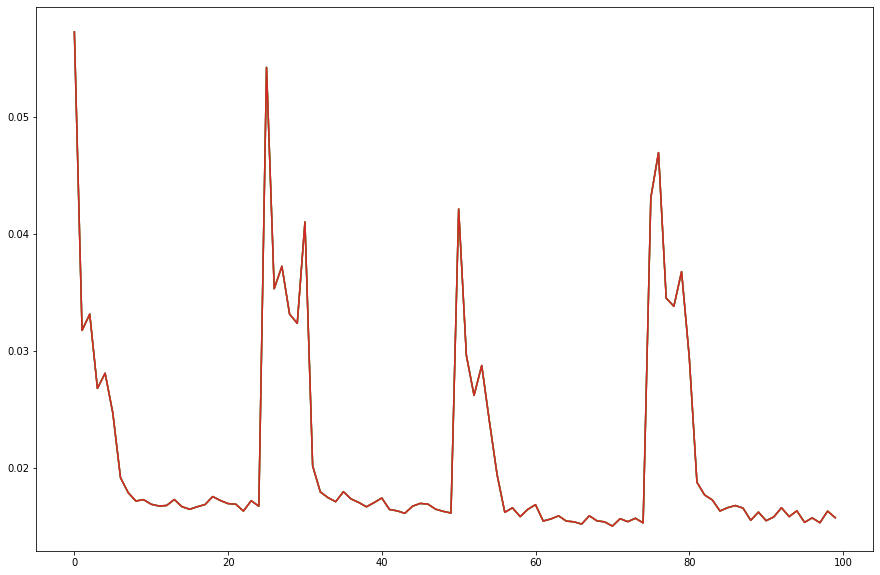

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(test_loss_noreg)
ax.plot(test_loss_l1)
ax.plot(test_loss_l2)
ax.plot(test_loss_l1l2)
plt.show()

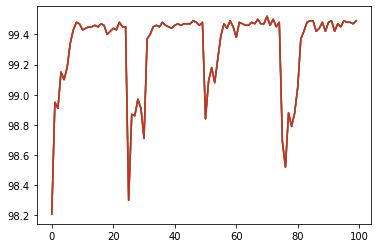

In [13]:
fig, ax = plt.subplots()
ax.plot(test_acc_noreg)
ax.plot(test_acc_l1)
ax.plot(test_acc_l2)
ax.plot(test_acc_l1l2)
plt.show()